In [37]:
# generally used modules
import numpy as np
import pandas as pd
from urllib.parse import urlparse

# pipeline feature engineering and scaling
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

# modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# model evaluation and parameter tuning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# model tracking
import mlflow
import mlflow.sklearn

# visualization
import matplotlib.pyplot as plt
from plotnine import (
    ggplot, geom_density, geom_errorbar, geom_line, geom_point, xlab, ylab,
    ggtitle, theme, facet_wrap, geom_boxplot, geom_violin, geom_bar,  aes
)

# internal modules
from houses_pipeline.constants import CATEGORICAL_COLUMNS, NUMERICAL_COLUMNS
from houses_pipeline.constants import ORDINALS, ORDINALS_ORDERING

from houses_pipeline.transformers import RareCategoriesReplacer

FileNotFoundError: [Errno 2] No such file or directory: 'VERSION'

### Load the houses data

In [ ]:
houses_df = pd.read_csv("../data/interim/train.csv")

### Split into train and test sets

In [ ]:
SPLIT_SEED = 111

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    houses_df.drop(['SalePrice', 'Id'], axis=1),
    houses_df['SalePrice'],
    train_size=0.8,
    random_state=SPLIT_SEED
)


In [ ]:
X_train.head(4)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition
632,20,RL,85.0,11900,Pave,Missing,Reg,Lvl,AllPub,Inside,...,0,0,0,0,Missing,Missing,0,4,WD,Family
1131,20,RL,63.0,10712,Pave,Missing,Reg,Lvl,AllPub,Inside,...,0,0,0,0,MnPrv,Missing,0,9,Oth,Abnorml
789,60,RL,NaN,12205,Pave,Missing,IR1,Low,AllPub,Inside,...,0,0,0,0,Missing,Missing,0,7,WD,Normal
572,60,RL,83.0,13159,Pave,Missing,IR1,HLS,AllPub,Corner,...,0,0,0,0,Missing,Missing,0,7,New,Partial


### Set numerical and categorical columns

In [ ]:
# cast categorical to an actual category type
categoricals = X_train.columns & CATEGORICAL_COLUMNS
numericals = X_train.columns & NUMERICAL_COLUMNS

other_cols = ['BsmtHalfBath', 'KitchenAbvGr', 'Fireplaces']
houses_df[categoricals] = houses_df[categoricals].apply(pd.Categorical, axis=0)
houses_df[other_cols] = houses_df[other_cols].apply(pd.Categorical, axis=0)

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_86669/4065300983.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_86669/4065300983.py:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.


### Linear Models

Here we are going to define a pipeline with recomended feature engineering and
encoding techniques like
 - Feature Scaling
 - Target Scaling
 - Categorical Encoding

In [ ]:
mlflow.get_tracking_uri()

'file:///Users/nikolashahpazov/projects/learning/houses-ds-project/notebooks/mlruns'

### Doing a repeated cross validation to evaluate the model

In [ ]:
repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=10)
scoring = {
    'rmse': lambda e, X, y: np.sqrt(mean_squared_error(y, e.predict(X))),
    'neg_mean_absolute_error': 'neg_mean_absolute_error'
}
scores = cross_validate(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    # scoring=scoring,
    cv=repeated_kfold,
    return_train_score=True
);

pd.DataFrame(scores)

/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/sklearn/pipeline.py", line 695, in score
    Xt = transform.transform(Xt)
  File "/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 763, in transform
    Xs = self._fit_transform(
  File "/usr/

,fit_time,score_time,test_score,train_score
0,0.281053,0.042096,NaN,0.902724
1,0.328997,0.041223,0.934851,0.865267
2,0.222727,0.108323,0.735976,0.893956
3,0.269464,0.041250,0.863411,0.877376
4,0.220375,0.044044,0.897971,0.864010
5,0.241526,0.037877,NaN,0.864744
6,0.269599,0.048998,0.891447,0.869192
7,0.199400,0.047464,0.745162,0.881355
8,0.423726,0.080343,0.891238,0.870384
9,0.466279,0.042410,0.418892,0.898986


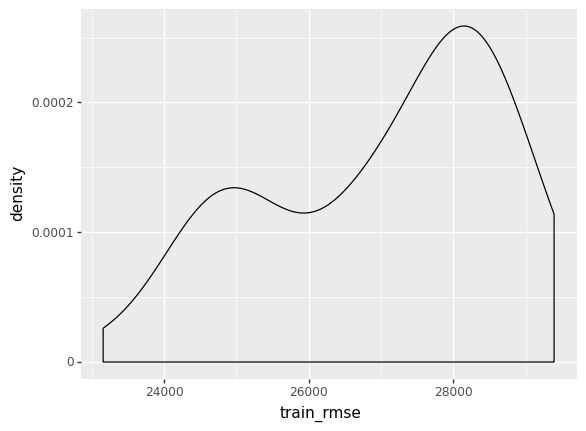

<ggplot: (401263601)>

In [ ]:
scores
ggplot(pd.DataFrame(scores)) + aes(x='train_rmse') + geom_density()

In [ ]:
experiment = mlflow.set_experiment(experiment_name="houses_lasso_regression")
experiment.experiment_id

'3'

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold, cross_val_score

__ordinal_encoder = OrdinalEncoder(
    categories=[ORDINALS_ORDERING] * len(ORDINALS),
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

experiment = mlflow.set_experiment(experiment_name="houses_lasso_regression")

with mlflow.start_run(experiment_id=experiment.experiment_id):

    MODEL_RANDOM_STATE = 123
    alpha = 0.002
    rare_threshold = 0.05

    # transformations to apply to the numerical predictors
    numeric_pipeline = Pipeline([
        ('impute_with_mean', SimpleImputer(strategy='mean')),
        ('scaling', StandardScaler()),
        ('yeo_johnson', PowerTransformer())
    ])

    categoric_pipeline = Pipeline(
        steps=[
            ('replace_rare', RareCategoriesReplacer(threshold=rare_threshold)),
            ('one_hot_encoding', OneHotEncoder()),
            # ('target_encode', TargetEncoder())
        ]
    )

    all_transformations = ColumnTransformer(
        transformers=[
            ('numeriric_transformations', numeric_pipeline, numericals),
            ('categoric_transformations', categoric_pipeline, categoricals),
            ('ordinals_encoding', __ordinal_encoder, ORDINALS)
        ],
        remainder='passthrough'
    )

    # transformations on the response variable
    response_variable_pipeline = Pipeline(
        steps=[
            ('normalization', StandardScaler()),
            ('yeo_johnson', PowerTransformer())
        ]
    )

    # track the experiment's transformations
    mlflow.log_param("rare_threshold", rare_threshold)
    mlflow.log_param("numeric_transformations", "impute_with_mean, norm, yj")
    mlflow.log_param("categorical_transformations", "replace_rare, ohe")
    mlflow.log_param("ordinals_transformations", "ordinal_encoding")
    mlflow.log_param("target_transformations", "norm, yj")

    pipeline = Pipeline(
        steps=[
            ('column_transformations', all_transformations),
            ('lasso_and_target_transform', TransformedTargetRegressor(
                regressor=Lasso(alpha=alpha),
                transformer=response_variable_pipeline
            ))
        ]
    )

    # fit the pipeline
    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # track model parameters and metrics
    mlflow.log_param('alpha', alpha)
    mlflow.log_param('model_random_seed', MODEL_RANDOM_STATE)
    mlflow.log_param('split_random_seed', SPLIT_SEED)

    # mlflow log metrics of the model
    # mlflow.log_metric("mean_cv_rmse", np.nanmean(scores))

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(
            pipeline, "model", registered_model_name="LassoRegression"
        )
    else:
        mlflow.sklearn.log_model(pipeline, "model")
        model_uri = mlflow.get_artifact_uri("model")

        result = mlflow.evaluate(
            model_uri,
            X_test.assign(y=y_test),
            targets="y",
            model_type="regressor",
            dataset_name="houses_test",
            evaluators=["default"]
        ) 


    # print(f"Train RMSE = {rmse_train}")
    # print(f"Test RMSE = {rmse_test}")

/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 108, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_86669/125330088.py", line 73, in <lambda>
    'rmse': lambda e, X, y: np.sqrt(mean_squared_error(y, e.predict(X))),
  File "/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/sklearn/pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "/usr/

{'fit_time': array([0.28072309, 0.33362293, 0.25080895, 0.37641501, 0.24369907,
       0.21098495, 0.29088521, 0.19749713, 0.25312424, 0.22367382]), 'score_time': array([0.07042003, 0.1175921 , 0.18458128, 0.08184505, 0.10709715,
       0.02705002, 0.07736897, 0.07398605, 0.08223367, 0.08139801]), 'test_rmse': array([ 18667.61106871, 106857.02455997,  36066.16565107,  46076.22675415,
        28643.26316591,             nan,  23069.35385381,  17946.34522489,
        24135.98207308,  19870.50920864]), 'train_rmse': array([28832.34945598, 25123.03742578, 26694.61381714, 27180.76821444,
       27935.82179431, 27247.94441423, 28596.96480158, 28924.21464652,
       28162.49247506, 28399.95641015]), 'test_neg_mean_absolute_error': array([-12926.67813525, -23661.13202913, -18093.50730078, -16467.48162828,
       -16908.09307008,             nan, -15305.86594311, -13368.10956396,
       -15559.51936372, -12854.37074589]), 'train_neg_mean_absolute_error': array([-14671.17069354, -13337.79556336,

2022/08/24 15:26:18 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2022/08/24 15:26:18 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


### Plot Actual vs predicted in the train set


In [ ]:
from sklearn.metrics import get_scorer_names
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

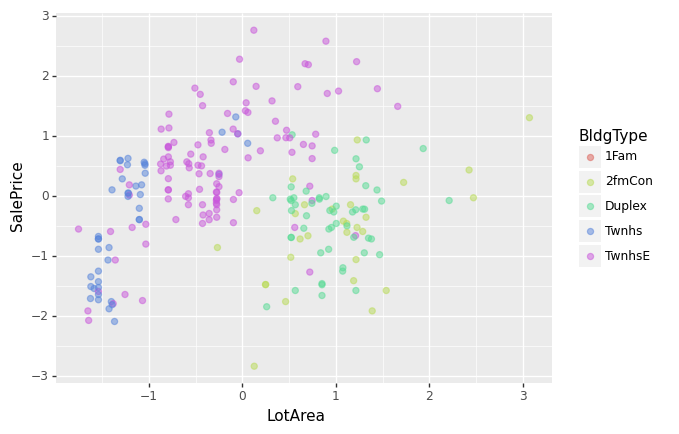

<ggplot: (383218170)>

In [ ]:
# result_df = X_train.assign(y=y_train, prediction=y_train_pred)
x = houses_df[houses_df.BldgType != '1Fam']
(x.assign(
    LotArea=numeric_pipeline.fit_transform(x[['LotArea']]),
    SalePrice=response_variable_pipeline.fit_transform(x[['SalePrice']])
).pipe(ggplot) + 
    aes(x='LotArea', y='SalePrice', color='BldgType') +
    geom_point(alpha=0.5, size=2)
)

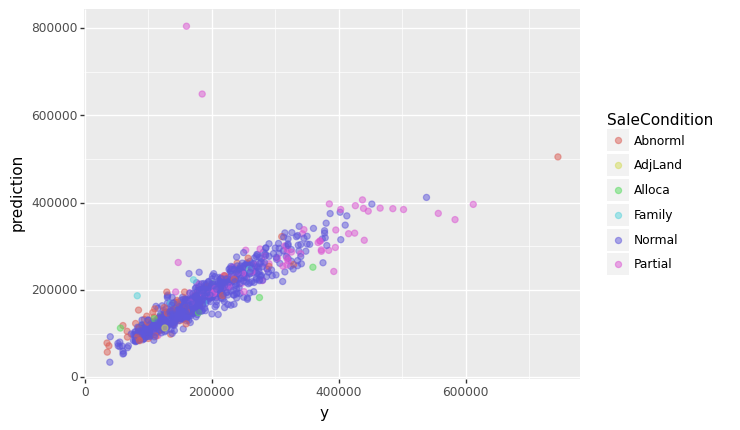

<ggplot: (383531665)>

In [ ]:
result_df = X_train.assign(y=y_train, prediction=y_train_pred)

ggplot(result_df) + aes(x='y', y='prediction', color='SaleCondition') + geom_point(alpha=0.5, size=2)

In [ ]:
result_df

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,SaleType,SaleCondition,y,prediction
632,20,RL,85.0,11900,Reg,Lvl,Inside,NWAmes,Norm,1Fam,...,544,192,0,0,NaN,4,WD,Family,82500,187419.654008
1131,20,RL,63.0,10712,Reg,Lvl,Inside,Mitchel,Norm,1Fam,...,0,0,28,0,MnPrv,9,Oth,Abnorml,93500,120536.479619
789,60,RL,NaN,12205,IR1,Low,Inside,ClearCr,Norm,1Fam,...,444,133,168,0,NaN,7,WD,Normal,187500,211580.925990
572,60,RL,83.0,13159,IR1,HLS,Corner,Timber,Norm,1Fam,...,650,208,114,0,NaN,7,New,Partial,224500,205391.852465
1349,70,RM,50.0,5250,Reg,Lvl,Inside,OldTown,Norm,1Fam,...,0,0,54,20,NaN,12,WD,Normal,122000,132030.149417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,50,RH,55.0,4500,IR2,Bnk,Inside,SWISU,Norm,1Fam,...,281,0,0,56,NaN,7,WD,Abnorml,159434,112945.141777
1299,20,RL,75.0,7500,Reg,Lvl,Inside,NAmes,Norm,1Fam,...,305,218,0,0,GdPrv,5,WD,Normal,154000,147050.479428
86,60,RL,122.0,11911,IR2,Lvl,Inside,Gilbert,Norm,1Fam,...,400,100,38,0,NaN,3,WD,Normal,174000,182629.757325
724,20,RL,86.0,13286,IR1,Lvl,Inside,Edwards,Norm,1Fam,...,768,327,64,0,NaN,2,WD,Normal,320000,327309.690879


In [ ]:
outliers_df = result_df[(result_df['prediction'] > 500000) & (result_df['y'] < 400000)]
outliers_df


,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,SaleType,SaleCondition,y,prediction
523,60,RL,130.0,40094,IR1,Bnk,Inside,Edwards,PosN,1Fam,...,884,208,406,0,NaN,10,New,Partial,184750,721519.593433
1298,60,RL,313.0,63887,IR3,Bnk,Corner,Edwards,Feedr,1Fam,...,1418,214,292,0,NaN,1,New,Partial,160000,889383.711419


We might say that the Shape is iregular with those houses which are of great lot area but low price

Land contour is never leveled\flat for those outliers.

In [ ]:
# Final model on the entire set
pipeline.fit(houses_df.drop(['SalePrice'], axis=1), houses_df['SalePrice'])

/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
/usr/local/Caskroom/miniconda/base/envs/houses/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


Pipeline(steps=[('column_transformations',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeriric_transformations',
                                                  Pipeline(steps=[('impute_with_mean',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler()),
                                                                  ('yeo_johnson',
                                                                   PowerTransformer())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsm...
                                                                              'Ex'],
                                                                             ['Missing',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['BsmtQual', 'ExterQual',
                                                   'ExterCond', 'FireplaceQu',
                                                   'KitchenQual'])])),
                ('lasso_and_target_transform',
                 TransformedTargetRegressor(regressor=Lasso(alpha=0.002),
                                            transformer=Pipeline(steps=[('normalization',
                                                                         StandardScaler()),
                                                                        ('yeo_johnson',
                                                                         PowerTransformer())])))])

In [ ]:
import joblib
# load the test dataset and produce predictions
test_df = pd.read_csv("../data/interim/test.csv")
predictions = pipeline.predict(test_df.fillna(0))

# generate a predictions data frame and write it to csv
predictions_df = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': predictions})
predictions_df.to_csv("../data/results/predictions.csv", index=False)